<a href="https://colab.research.google.com/github/mweiher15/AICapstone/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net









Comp 484 AI

Yeheng Zong, Max Weiher, Lien Lian

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np

from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate



In [ ]:
import os
import pandas as pd

import imageio


path = ''
image_path = '/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person1000/'
mask_path = '/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person_mask1000/'


image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)


image_list = sorted([image_path+i for i in image_list])
mask_list = sorted([mask_path+i for i in mask_list])


Here are some sample images from COCO dataset and their segmentation(mask).

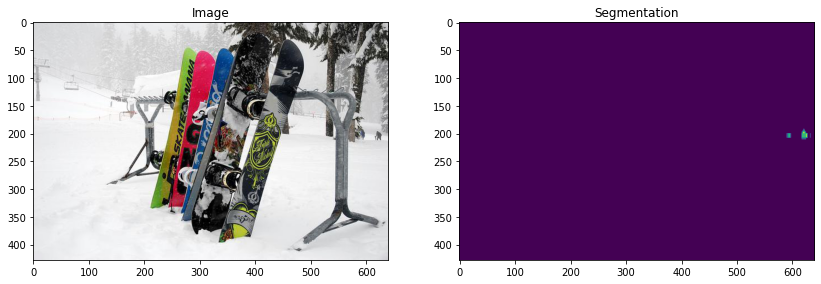

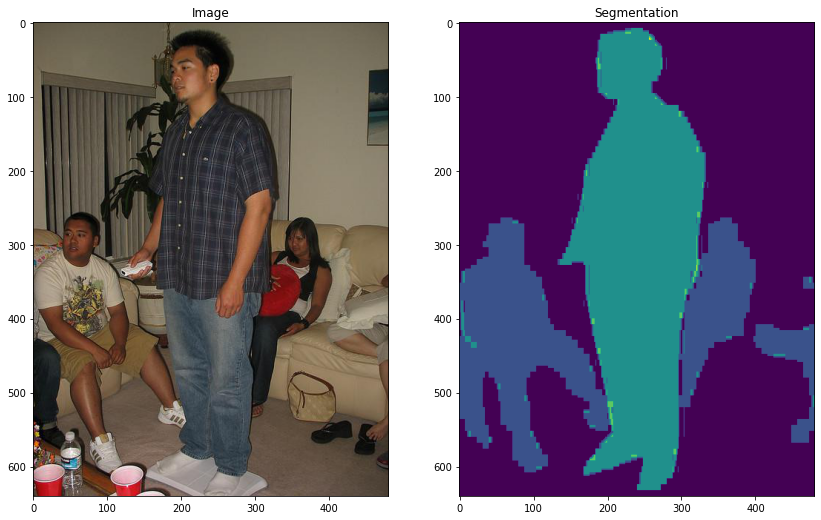

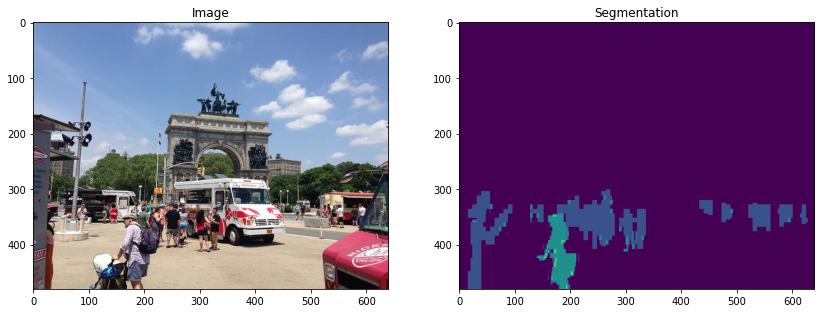

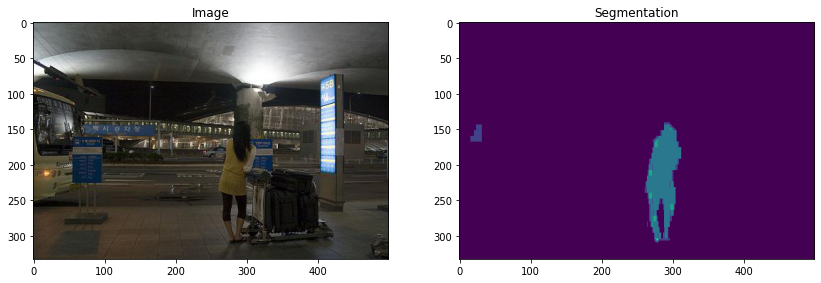

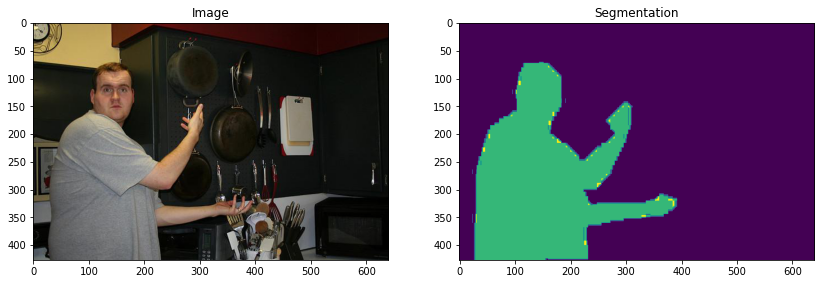

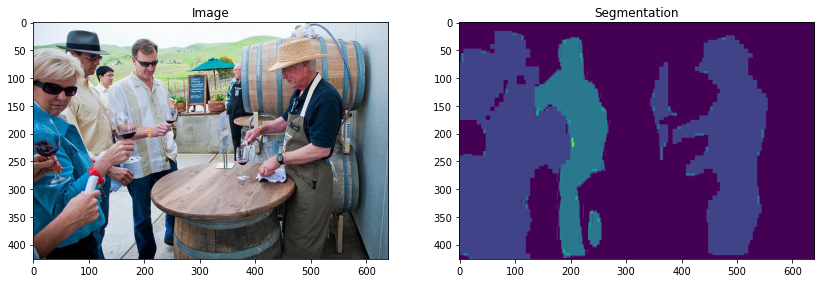

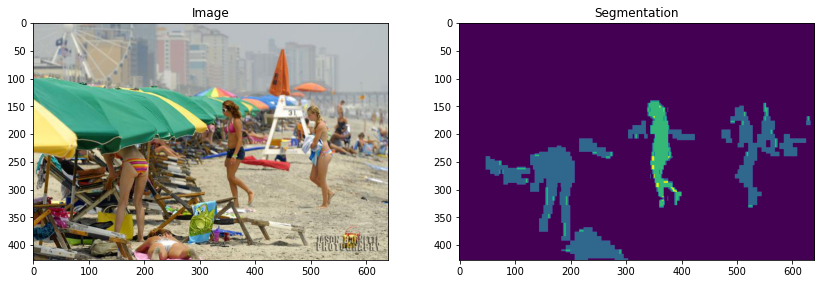

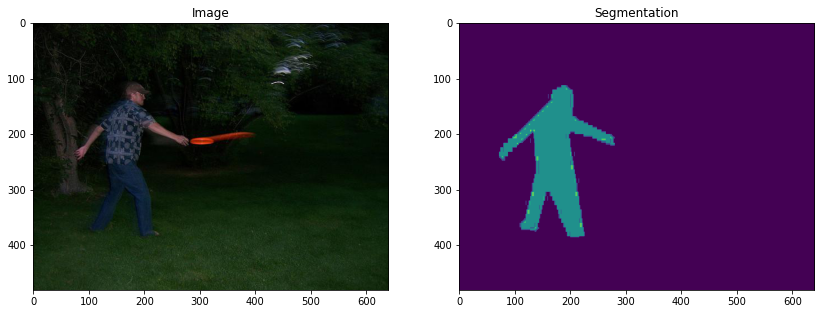

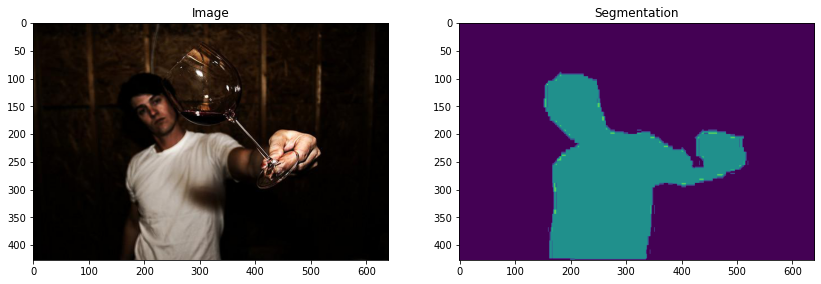

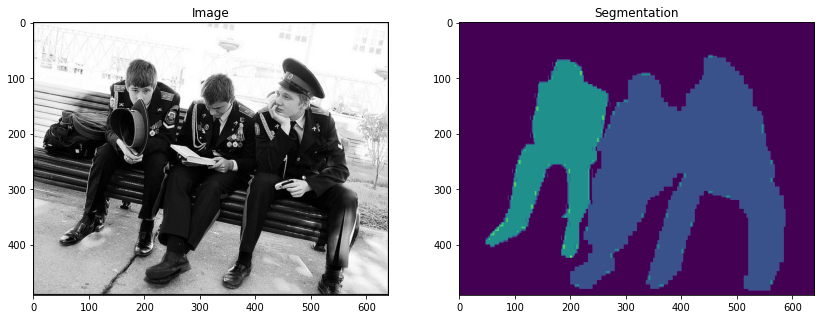

In [ ]:
for N in range(15,25):


  img = imageio.imread(image_list[N])
  mask = imageio.imread(mask_list[N])

  fig, arr = plt.subplots(1, 2, figsize=(14, 10))
  
  arr[0].imshow(img)
  arr[0].set_title('Image')
  arr[1].imshow(mask)
  arr[1].set_title('Segmentation')

From here we started data pre-processing. First, we transfer the image
and mask into tf.Dataset. We resized each tf.image in tf.Dataset 
with shape (96, 128), and then make the label value only 0 and 1.
The numerical value 0 represents background and 1 represents human. 
After the preprocessing, we pick 90% of them as training data and 
10% of them as validation data. 

---



In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person1000/000000000036.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person_mask1000/000000000036.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person1000/000000000049.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person_mask1000/000000000049.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person1000/000000000061.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person_mask1000/000000000061.jpg'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)


tf.Tensor(b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person1000/000000000036.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Comp484_AI_Project_UNet/train_person_mask1000/000000000036.jpg', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    input_mask = tf.where(input_mask > 0, 1, 0)
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
processed_image_ds_train = processed_image_ds.take(900)
processed_image_ds_val = processed_image_ds.skip(900).take(100)

processed_image_ds_choice = processed_image_ds.skip(1000).take(4)

The downsampling convolutional block in the encoder of U-Net is defined below.
In each downsampling block, two $3 \times 3$ convolutional layer is applied with same padding. A rectified linear unit (ReLU), a $2 \times 2$ max pooling layer with stride $2$ and a drop out layer with drop out rate $0.3$ are followed after each convolutional layer. At each downsampling block, the number of feature channels is doubled by doubling the number of filters, with initial number of filters equals to $32$. The encoder helps the network to catch high-level contextual information contained in input images.
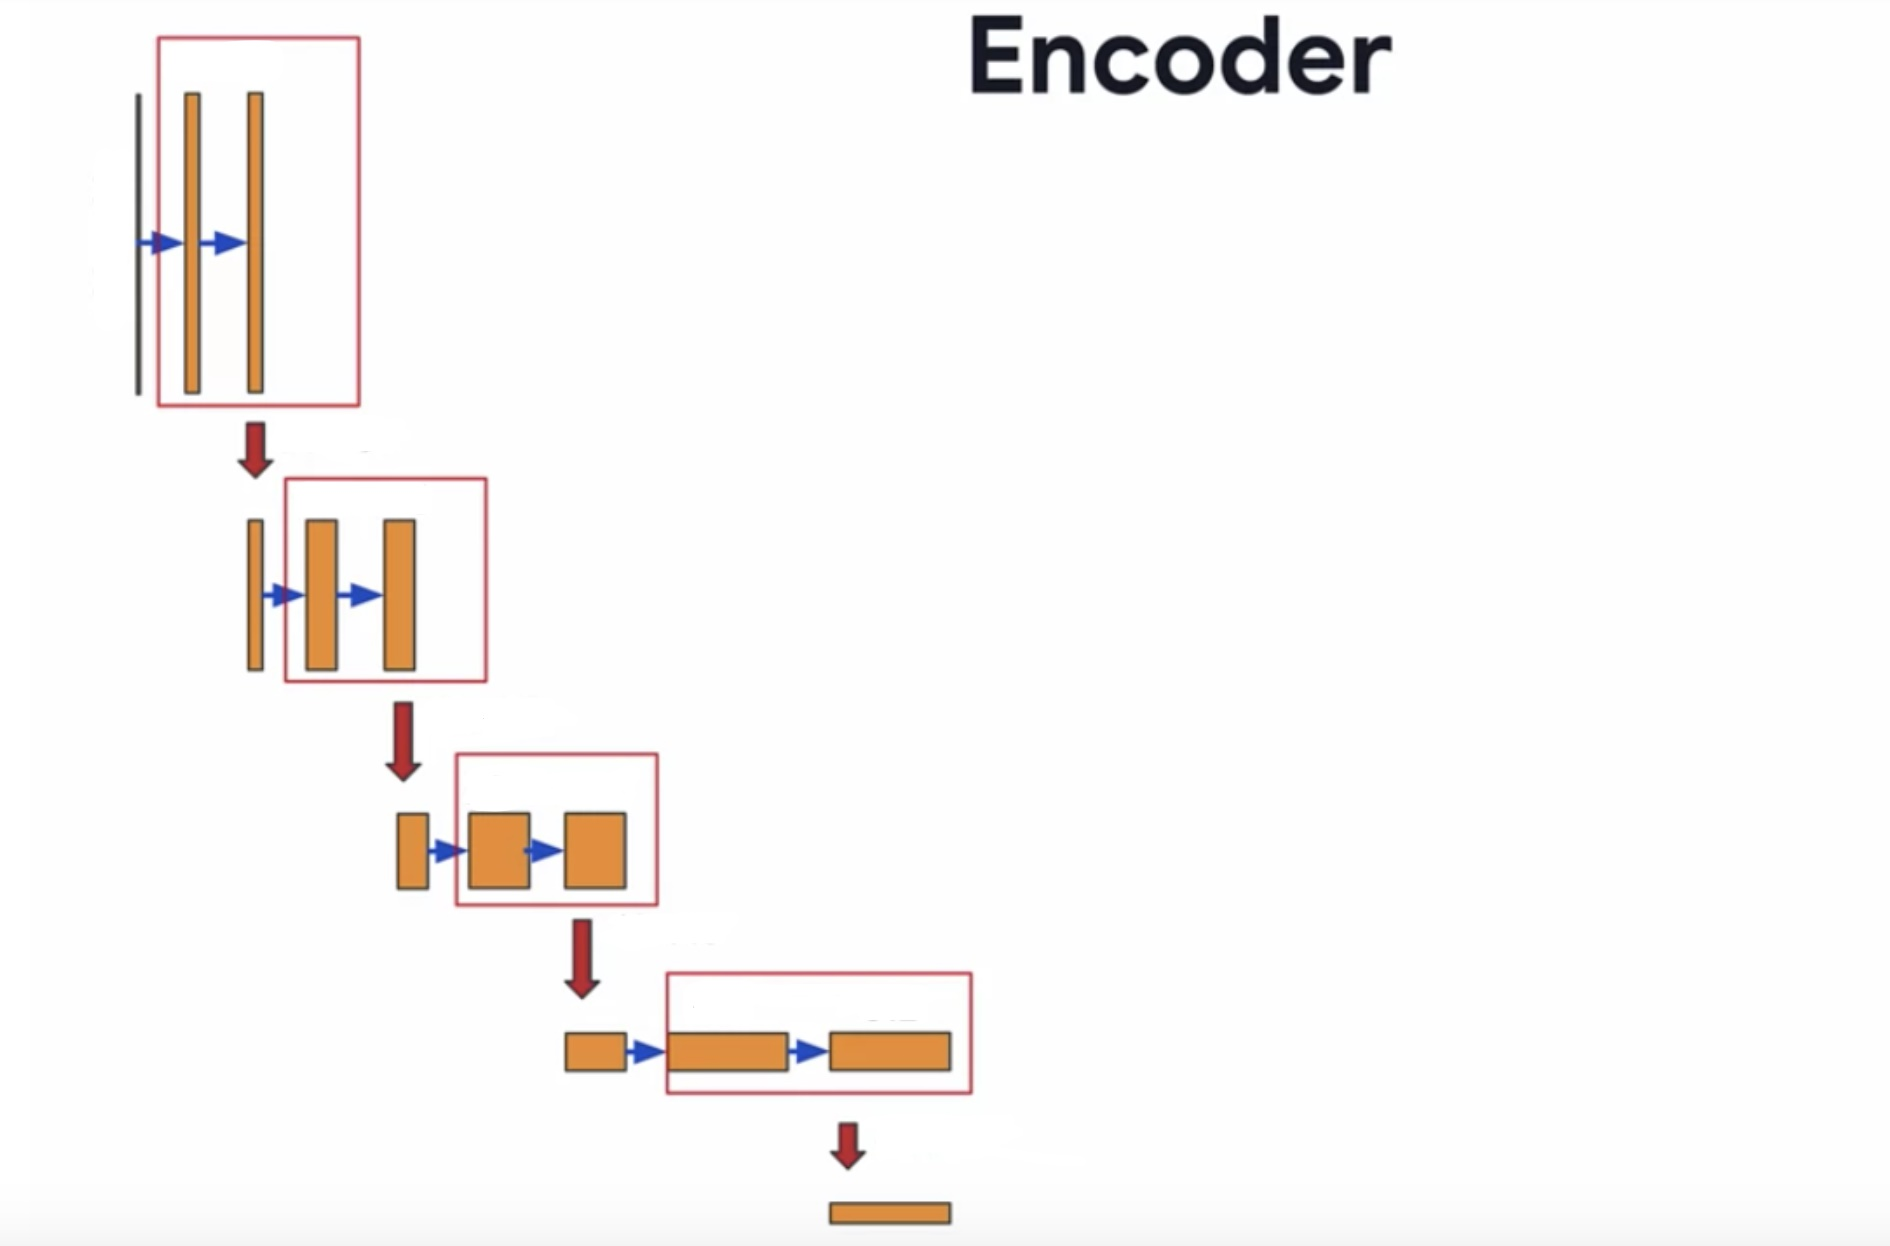

In [ ]:
def downsampling_conv(input=None, num_filters=32, dropout_prob = 0, max_pooling=True):
  conv = Conv2D(num_filters, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(input)
  conv = Conv2D(num_filters, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)

  if dropout_prob > 0:
    conv = Dropout(rate = dropout_prob)(conv)
  
  if max_pooling:
    next_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv)
  else:
    next_layer = conv
  
  skip_connection = conv

  return next_layer, skip_connection


The unsampling transpose convolutional network is defined below.In each upsampling block, a $3 \times 3$ transpose convolutional layer with same padding and strides $2$ is firstly applied. Then, the output of this convolutional layer is concatenate with one of the output from the downsampling block. This step is called the skip connection. The purpose and function of this step is to remain detailed information in the original image to allow more precise segmentation. After the concatenation, two $3 \times 3$ convolutional layer with same number of filters, ReLU activation and same padding is applied. The output from the last upsamling block will first be passed to a $3 \times 3$ convolutional layer with same number of filters as the one in the last upsampling block, ReLU activation, and same padding; and then it will be passed to a $1 \times 1$ convolutional later with number of filters equals to number of label class and same padding.
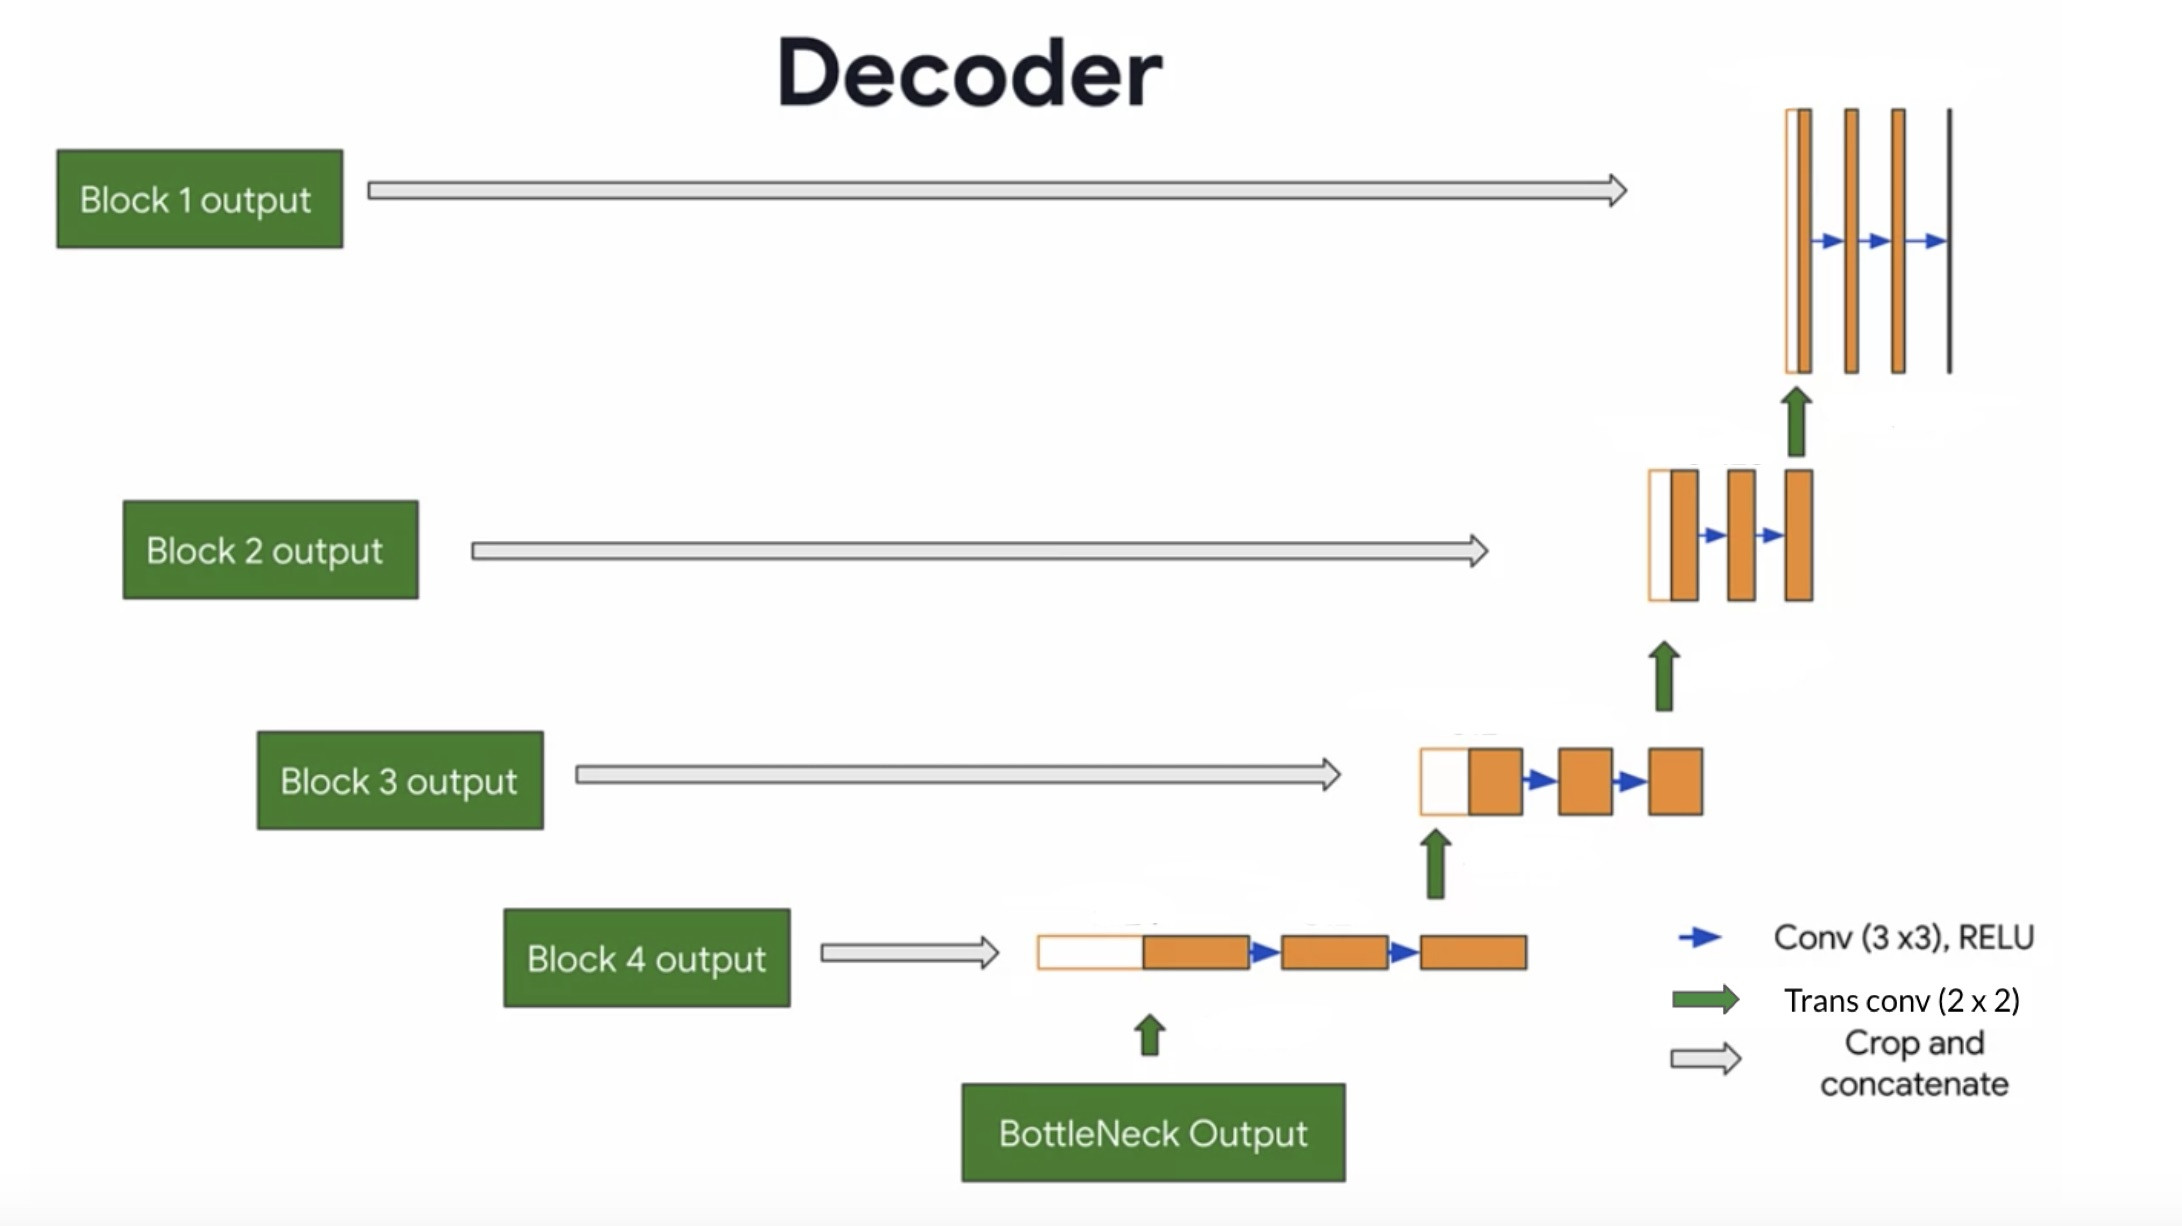

In [ ]:
def upsampling_Tconv(conv_input, skip_input, num_filters):

  upsample = Conv2DTranspose(num_filters, (3, 3), padding="same", strides=(2, 2))(conv_input)

  combine =  concatenate([upsample, skip_input], axis=3)

  conv = Conv2D(num_filters, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(combine)
  conv = Conv2D(num_filters, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)

  return conv


Here is the function that create the unet model. 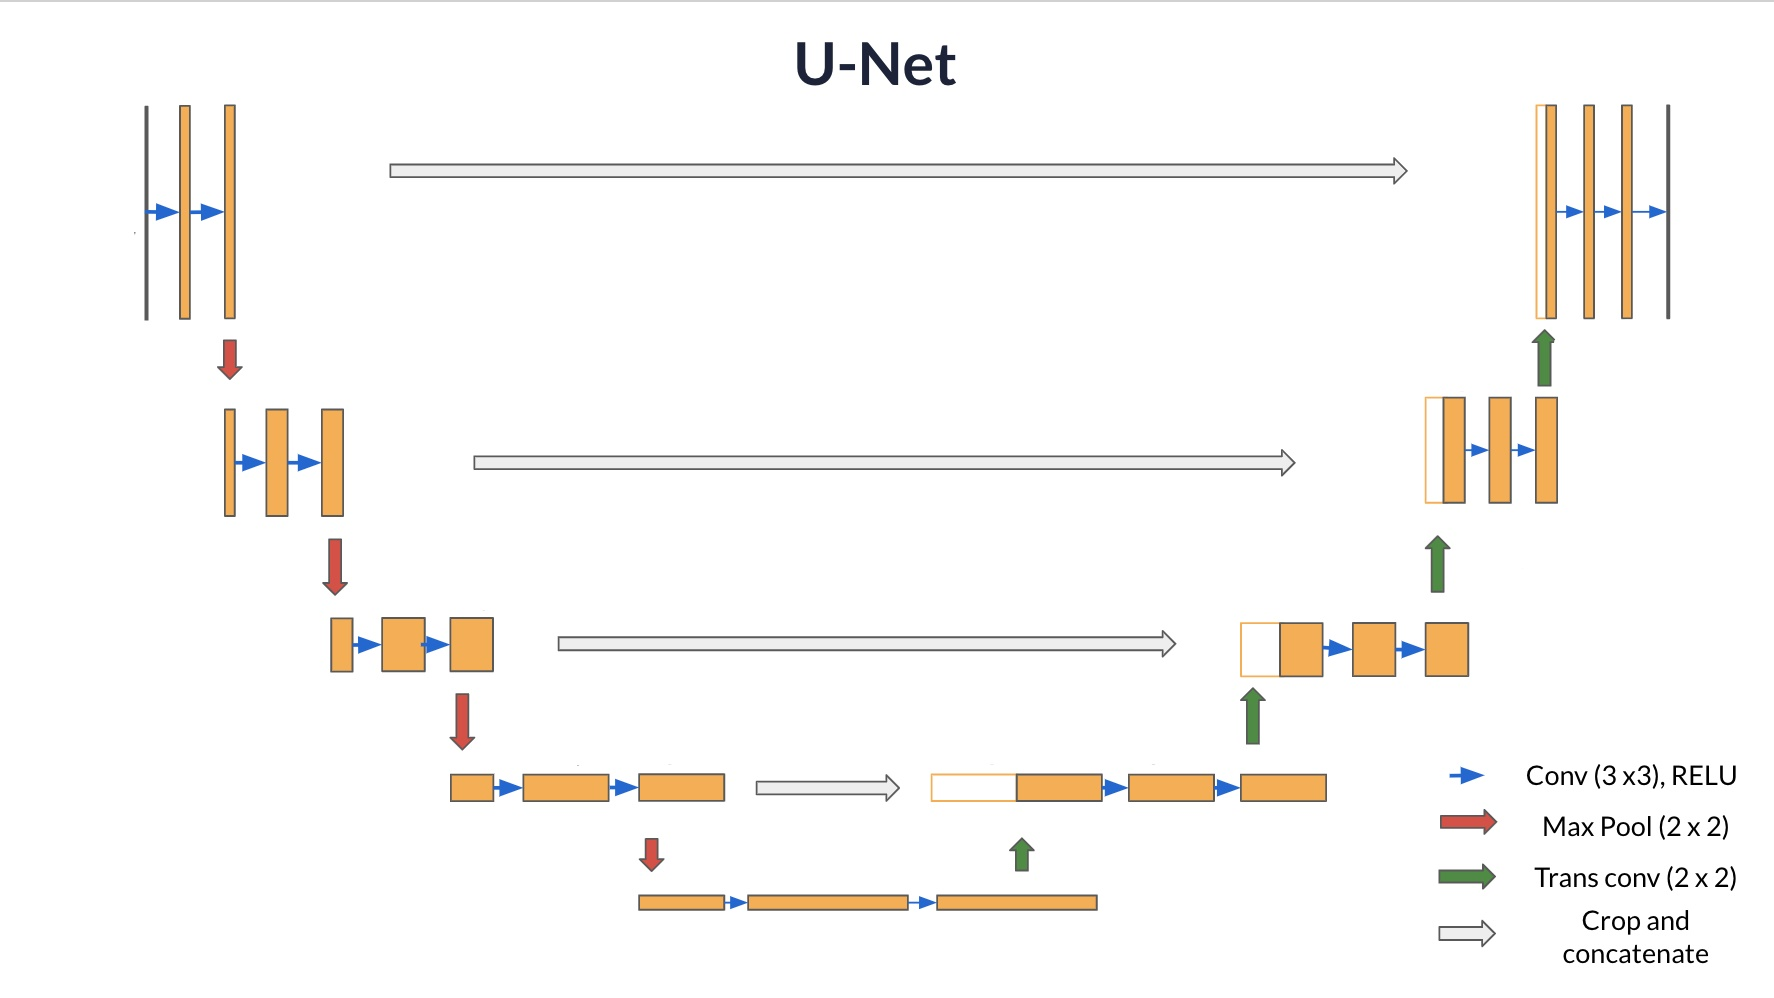

In [ ]:
def unet_model(input_shape, num_filters, num_classes):

  inputs = Input(input_shape)
  convBlock1 = downsampling_conv(inputs, num_filters, 0)
  convBlock2 = downsampling_conv(convBlock1[0], num_filters*2, 0.3)
  convBlock3 = downsampling_conv(convBlock2[0], num_filters*4, 0.3)
  convBlock4 = downsampling_conv(convBlock3[0], num_filters*8, 0.3)
  convBlock5 = downsampling_conv(convBlock4[0], num_filters*16, 0.3, max_pooling=False)

  upBlock6 = upsampling_Tconv(convBlock5[0], convBlock4[1], num_filters*8)
  upBlock7 = upsampling_Tconv(upBlock6, convBlock3[1], num_filters*4)
  upBlock8 = upsampling_Tconv(upBlock7, convBlock2[1], num_filters*2)
  upBlock9 = upsampling_Tconv(upBlock8, convBlock1[1], num_filters)

  conv9 = Conv2D(num_filters, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(upBlock9)
  conv10 = Conv2D(num_classes, (1, 1), padding= "same")(conv9)

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model


Starting from here, we defined out model, compiled it and trained it.
The optimizer we used is 'adam'; the loss function we chose is sparse categorical cross entropy loss; and the metrics is accuracy. We trained
the model for 80 epochs and for each epochs, all 900 training data is
shuffled and then split into 29 batches with batch size 32. 

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), 32, 2)

In [ ]:
unet.summary()

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
EPOCHS = 80
BUFFER_SIZE = 900 # set datasize
BATCH_SIZE = 32
train_dataset = processed_image_ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = processed_image_ds_val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
choice_dataset = processed_image_ds_choice.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)
print(val_dataset)
print(choice_dataset)



<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.int32, name=None))>


In [ ]:
model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/80
29/29 [==============================] - 24s 355ms/step - loss: 0.5482 - accuracy: 0.8398 - val_loss: 0.4577 - val_accuracy: 0.8350
Epoch 2/80
29/29 [==============================] - 5s 169ms/step - loss: 0.4230 - accuracy: 0.8455 - val_loss: 0.4357 - val_accuracy: 0.8350
Epoch 3/80
29/29 [==============================] - 5s 170ms/step - loss: 0.4063 - accuracy: 0.8455 - val_loss: 0.4117 - val_accuracy: 0.8350
Epoch 4/80
29/29 [==============================] - 5s 168ms/step - loss: 0.3950 - accuracy: 0.8455 - val_loss: 0.3974 - val_accuracy: 0.8350
Epoch 5/80
29/29 [==============================] - 5s 168ms/step - loss: 0.3765 - accuracy: 0.8452 - val_loss: 0.3932 - val_accuracy: 0.8350
Epoch 6/80
29/29 [==============================] - 5s 166ms/step - loss: 0.3749 - accuracy: 0.8456 - val_loss: 0.3853 - val_accuracy: 0.8352
Epoch 7/80
29/29 [==============================] - 5s 166ms/step - loss: 0.3652 - accuracy: 0.8459 - val_loss: 0.3639 - val_accuracy: 0.8385
Epoch

In [ ]:
unet.save('/content/drive/MyDrive/Comp484_AI_Project_UNet/unet_model')


In [ ]:
unet_model = tf.keras.models.load_model('/content/drive/MyDrive/Comp484_AI_Project_UNet/unet_model')

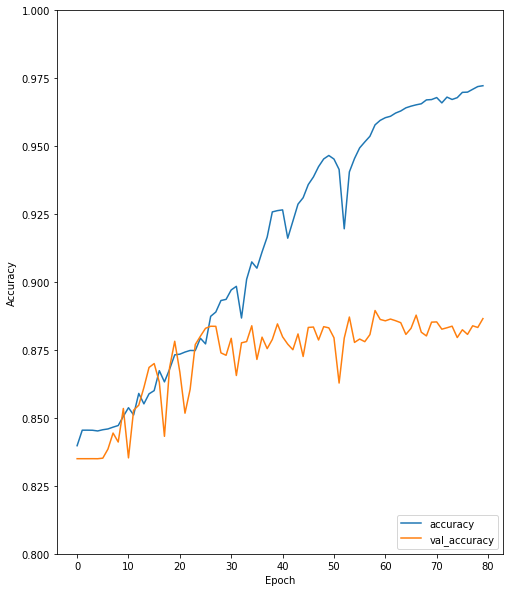

In [ ]:
plt.plot(model_history.history["accuracy"], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

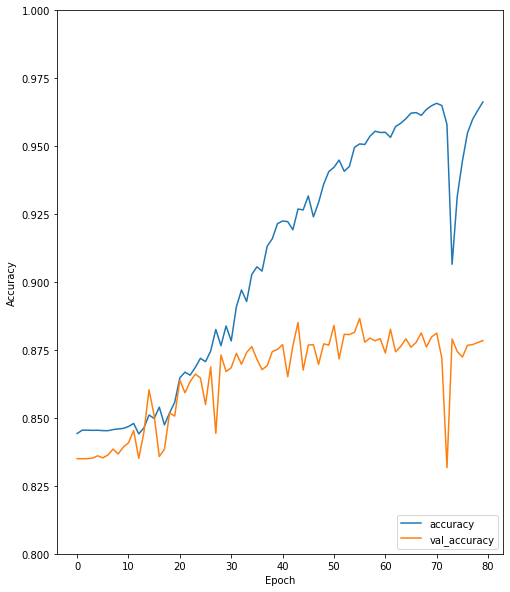

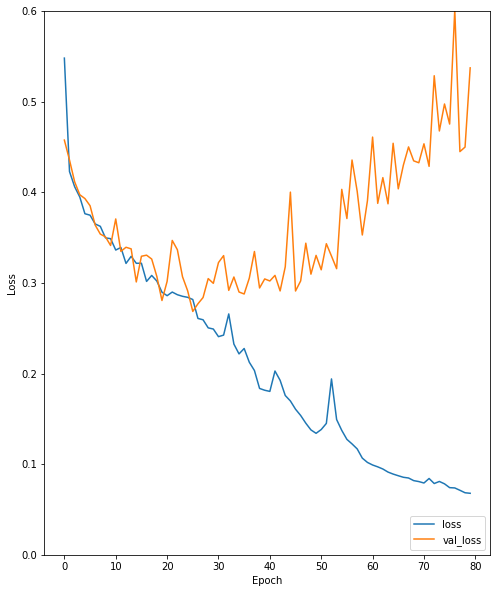

In [ ]:
plt.plot(model_history.history["loss"], label='loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.6])
plt.legend(loc='lower right')

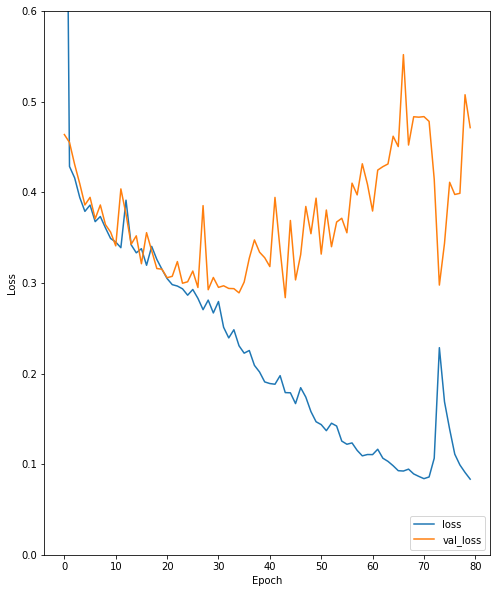

Some helper functions that can help us visualize prediction of U-Net.

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        print(display_list[i].shape, display_list[i].dtype)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display_mask = create_mask(pred_mask)
            output = np.zeros(shape = (96, 128, 3))
            output[:,:,] = display_mask
            output[:,:,] = display_mask
            output[:,:,] = display_mask
            display([image[0], mask[0], output+ image[0]])
           
    else:

      display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
        
        
    

1/1 [==============================] - 0s 23ms/step
(96, 128, 3) <dtype: 'float32'>
(96, 128, 1) <dtype: 'int32'>
(96, 128, 3) <dtype: 'float32'>


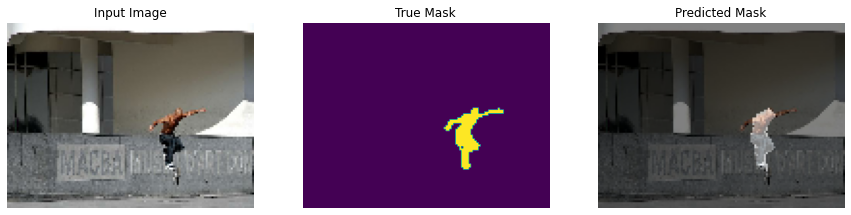

1/1 [==============================] - 0s 27ms/step
(96, 128, 3) <dtype: 'float32'>
(96, 128, 1) <dtype: 'int32'>
(96, 128, 3) <dtype: 'float32'>


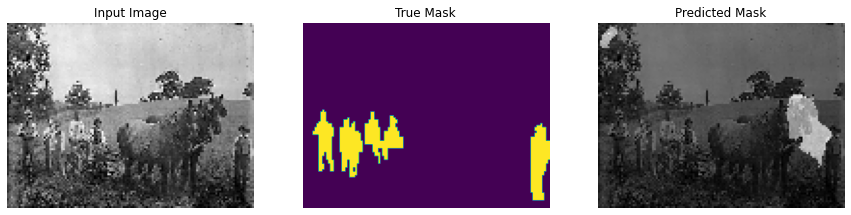

1/1 [==============================] - 0s 23ms/step
(96, 128, 3) <dtype: 'float32'>
(96, 128, 1) <dtype: 'int32'>
(96, 128, 3) <dtype: 'float32'>


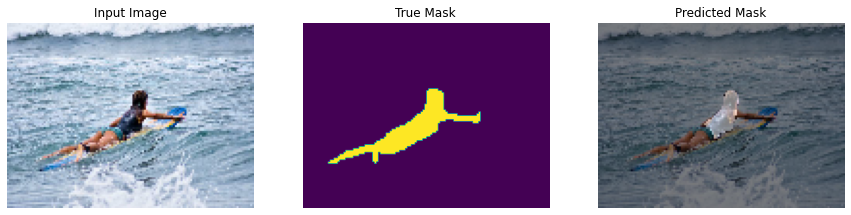

1/1 [==============================] - 0s 24ms/step
(96, 128, 3) <dtype: 'float32'>
(96, 128, 1) <dtype: 'int32'>
(96, 128, 3) <dtype: 'float32'>


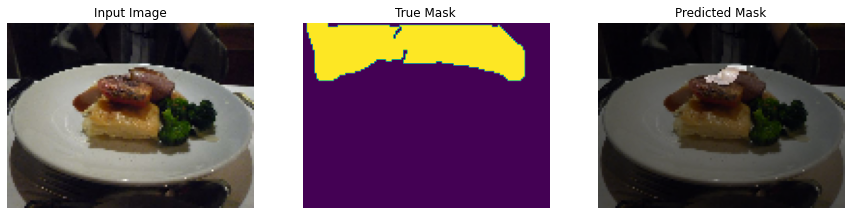

In [ ]:
show_predictions(val_dataset, 6)

Experiments for the draw-green-line algorithm.

In [ ]:
test_mask = []
for image, mask in processed_image_ds.take(10):
    sample_image, sample_mask = image, mask
    test_mask.append(sample_mask)


In [ ]:
# test_mask = []
# for image, mask in processed_image_ds_choice.take(4):
#     sample_image, sample_mask = image, create_mask(unet_model.predict(image[tf.newaxis, ...]))
#     test_mask.append(sample_mask)


1/1 [==============================] - 0s 29ms/step


In [ ]:
#green line points


averagePoints = []

#finding each y value that has pixels of value 1 and 
#finding the average x value for each value y 

for i in range(96):
  figureXValues = []
  xSum = 0
  for j in range(128):
    if test_mask[0][i][j] == 1:
      figureXValues.append(j)
  for xValue in figureXValues:
    xSum = xSum + xValue
  if len(figureXValues) > 0:
    average = xSum / len(figureXValues)
    averagePoints.append((average, -i)) # I flip the sign of the y value here
                                        # to make the slope later more
                                        # understandable

print(averagePoints)




[(70.0, -25), (70.5, -26), (70.5, -27), (69.5, -28), (70.0, -29), (70.5, -30), (71.5, -31), (72.0, -32), (72.0, -33), (72.0, -34), (71.5, -35), (71.5, -36), (71.5, -37), (72.5, -38), (72.5, -39), (73.0, -40), (73.5, -41), (74.0, -42), (75.5, -43), (76.0, -44), (76.0, -45), (78.0, -46), (78.0, -47), (77.5, -48), (75.5, -49), (74.0, -50), (74.0, -51), (74.5, -52), (74.5, -53), (75.0, -54), (74.5, -55), (75.0, -56), (75.0, -57), (75.5, -58), (76.0, -59), (76.5, -60), (77.0, -61), (78.0, -62), (78.0, -63), (78.0, -64), (78.5, -65), (79.0, -66), (79.5, -67), (80.5, -68), (80.5, -69), (80.5, -70), (81.0, -71), (82.0, -72), (82.21311475409836, -73), (82.40677966101696, -74), (82.40677966101696, -75), (82.91379310344827, -76), (83.63157894736842, -77), (84.17241379310344, -78), (89.54347826086956, -79), (90.3125, -80), (90.3125, -81), (89.5, -82), (89.54, -83), (88.7, -84), (88.98113207547169, -85), (88.70370370370371, -86), (88.70370370370371, -87), (89.2280701754386, -88), (88.59649122807018

-2.8772301710505888
(96, 128, 1) <dtype: 'int32'>


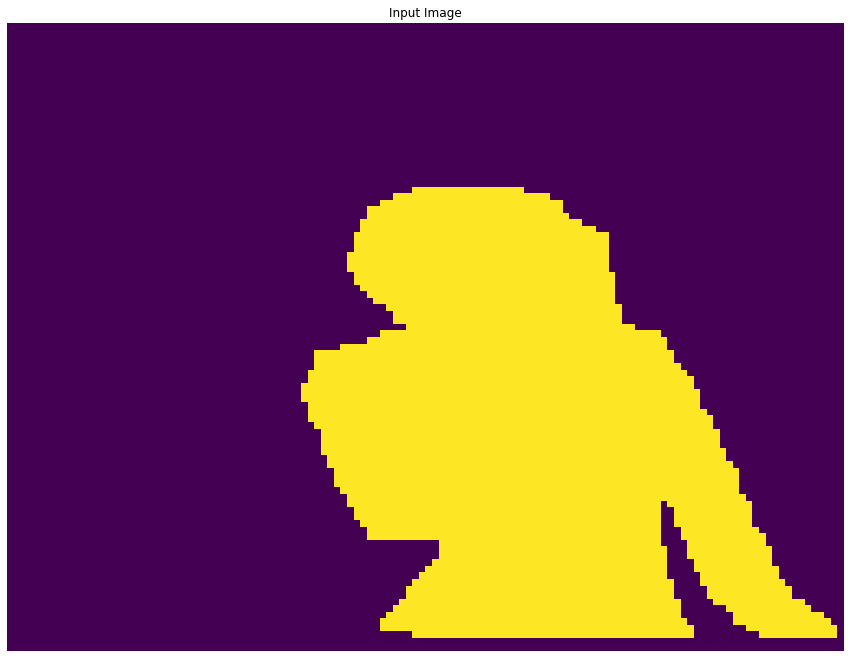

In [ ]:
# finding the equation for regression line for averagePoints
# from https://www.varsitytutors.com/hotmath/hotmath_help/topics/line-of-best-fit

xSum = 0
ySum = 0

for pair in averagePoints:
  xSum = xSum + pair[0]
  ySum = ySum + pair[1]

avgX = xSum / len(averagePoints)
avgY = ySum / len(averagePoints)

productArray = []
squareArray = []

for pair in averagePoints:
  pointSubAvgSumX = pair[0] - avgX
  pointSubAvgSumY = pair[1] - avgY
  productArray.append(pointSubAvgSumX * pointSubAvgSumY)
  squareArray.append(pointSubAvgSumX * pointSubAvgSumX)

productSum = 0
squareSum = 0

for item in productArray:
  productSum = productSum + item

for item in squareArray:
  squareSum = squareSum + item

slope = productSum / squareSum
print(slope) # if positive, left person is dependent
             # if negative, right person is dependent

display([test_mask[0]])
